In [1]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from opts import parse_opts
from model import generate_model
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop, TemporalBeginCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
from datasets.moments import Moments
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
from scipy.misc import imresize as imresize
import cv2
from PIL import Image

In [2]:
opt_root_path = './data'
opt_video_path = 'Moments_in_Time_Mini/jpg'
opt_annotation_path = 'moments.json'
opt_result_path = 'results/ResNet50_5_255'
opt_dataset = 'moments'
opt_resume_path = 'results/ResNet50_5_255/save_10.pth'
opt_n_classes = 200
opt_model = 'resnet'
opt_model_depth = 50
opt_resnet_shortcut = 'B'
opt_batch_size = 1
opt_n_threads = 4
opt_checkpoint = 5
opt_norm_value = 1
opt_mean_dataset = 'moments'
opt_sample_size = 112
opt_scale_in_test = 1.0
opt_crop_position_in_test = 'c'
opt_sample_duration = 16

In [3]:
if opt_root_path != '':
    opt_video_path = os.path.join(opt_root_path, opt_video_path)
    opt_annotation_path = os.path.join(opt_root_path, opt_annotation_path)
    opt_result_path = os.path.join(opt_root_path, opt_result_path)
    opt_resume_path = os.path.join(opt_root_path, opt_resume_path)
opt_arch = '{}-{}'.format(opt_model, opt_model_depth)
opt_mean = get_mean(opt_norm_value, dataset=opt_mean_dataset)
opt_std = get_std(opt_norm_value)
    
norm_method = Normalize(opt_mean, [1, 1, 1])

In [4]:
def load_annotation_data(data_file_path):
    with open(data_file_path, 'r') as data_file:
        return json.load(data_file)

def get_class_labels(data):
    class_labels_map = {}
    index = 0
    for class_label in data['labels']:
        class_labels_map[class_label] = index
        index += 1
    return class_labels_map

data = load_annotation_data(opt_annotation_path)
class_to_idx = get_class_labels(data)
idx_to_class = {}
for name, label in class_to_idx.items():
    idx_to_class[label] = name

In [5]:
spatial_transform = Compose([
    Scale(int(opt_sample_size / opt_scale_in_test)),
    CornerCrop(opt_sample_size, opt_crop_position_in_test),
    ToTensor(opt_norm_value), norm_method
])

In [6]:
temporal_transform = TemporalBeginCrop(opt_sample_duration)

In [7]:
target_transform = ClassLabel()

In [8]:
valid_data= Moments(opt_video_path,
            opt_annotation_path,
            'validation',
            spatial_transform=spatial_transform,
            temporal_transform=temporal_transform,
            target_transform=target_transform)

dataset loading [0/10000]
dataset loading [1000/10000]
dataset loading [2000/10000]
dataset loading [3000/10000]
dataset loading [4000/10000]
dataset loading [5000/10000]
dataset loading [6000/10000]
dataset loading [7000/10000]
dataset loading [8000/10000]
dataset loading [9000/10000]


In [9]:
model = resnet.resnet50(
                num_classes=opt_n_classes,
                shortcut_type=opt_resnet_shortcut,
                sample_size=opt_sample_size,
                sample_duration=opt_sample_duration)
model = model.cuda()
model = nn.DataParallel(model, device_ids=None)

/media/jasonzy/Data/Stanford/Spring2018/CS231n/fp/project-moments/models/resnet.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [10]:
checkpoint = torch.load(opt_resume_path)
assert opt_arch == checkpoint['arch']
model.load_state_dict(checkpoint['state_dict'])
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (dow

In [11]:
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

In [12]:
model._modules['module'].layer4.register_forward_hook(hook_feature)
model._modules['module'].avgpool.register_forward_hook(hook_feature)

In [13]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

In [14]:
params = list(model.parameters())
weight_softmax = params[-2].cpu().data.numpy()
weight_softmax[weight_softmax<0] = 0

In [15]:
features_blobs = []

In [16]:
logit = model.forward(valid_data.__getitem__(1)[0].unsqueeze(0))

In [17]:
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
idx = idx.cpu().data.numpy()

In [18]:
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

/home/jasonzy/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [19]:
img = valid_data.__getitem__(1)[0][:,8,:,:].transpose(0,1).transpose(1,2).cpu().data.numpy()

In [20]:
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = (heatmap * 0.4 + img * 0.5)

In [21]:
cv2.imwrite('cam.jpg', result)

True

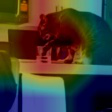

In [22]:
result_pic = Image.open('cam.jpg')
result_pic

In [23]:
print('Ground Truth:')
print(idx_to_class[valid_data.__getitem__(1)[1]])

Ground Truth:
licking


In [24]:
print('--Top Actions:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], idx_to_class[idx[i]]))

--Top Actions:
0.228 -> shaking
0.159 -> whistling
0.056 -> brushing
0.037 -> painting
0.035 -> howling
